In [1]:
import pickle
import json
import os
import sys
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import skimage
import tifffile
import yaml

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [6]:
run_dir = '/data/estorrs/mushroom/data/projects/kelsey_samples'
case = 'SN001H1_xenium'

## define inputs

In [7]:
z_scaler = .2
cluster_resolutions = [1., 1.25, 1.5]
# nbhd_resolutions = [50]
target_res = 50

In [8]:
# fix issues where antibody names aren't consistent accross some images
channel_to_idents = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'PanCK', 'PanCytokeratin'],
    'E-cadherin': ['E-cadherin', 'E-Cadherin'],
    'CD45': ['CD45'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin', 'Vim', 'VIM'],
    'SMA': ['SMA', 'a-SMA'],
    'CD31': ['CD31'],
    'CD20': ['CD20', 'CD20-Akoya'],
    'CD68': ['CD68'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKit', 'cKIT', 'ckit-(D)', 'ckit'],
    'MGP': ['MGP'],
    'CD36': ['CD36'],
    'PR': ['PR'],
    'ER': ['ER'],
    'P21': ['P21'],
    'P16': ['P16'],
    'CK5': ['Keratin 5', 'KRT5', 'CK5'],
    'CK7': ['CK7'],
    'CK8/18': ['CK8/18'],
    'TFF1': ['TFF1'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'KRT14'],
    'CK17': ['CK17', 'Keratin 17', 'CK17'],
    'CK19': ['CK19', 'Keratin 19', 'KRT19'],
    'CD11b': ['CD11b', 'CD11B', 'cd11b'],
    'GATA3': ['GATA3'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT'],
    'COX6c': ['COX6c', 'COX6C (D)', 'COX6C'],
    'Her2': ['Her2', 'HER2'],
    'Bap1': ['Bap1', 'BAP1'],
    'GLUT1': ['Glut1', 'GLUT1'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR', 'HLADR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN'],
    'CTLA4': ['CTLA4'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3'],
    'PTPRZ1': ['PTPRZ1'],
    'HIF1A': ['HIF1a', 'HIF1A'],
    'PAI1': ['PAI1'],
    'GFAP': ['GFAP'],
    'VEGFA': ['VEGFA'],
    'IBA1': ['IBA1'],
    'OLIG2': ['OLIG2'],
    'FN1': ['FN1'],
    'a-Amylase': ['a-Amylase', 'Amylase (D', 'Amylase'],
    'Hep-Par-1': ['Hep-Par-1', 'HepPar1-(D)', 'HepPar1'],
    'Granzyme-B': ['Granzyme B', 'GZMB'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1', 'PD1'],
    'PDL1': ['PD-L1', 'PDL1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63', 'p63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1', 'LYVE1'],
    'CCL2': ['CCL2'],
    'MUC2': ['MUC2'],
    'SOX9': ['SOX9'],
    'STEAP4': ['STEAP4'],
    'AR': ['AR'],
    'AMACR': ['AMACR'],
    'PGC': ['PGC', 'PGC (D)'],
    'CFTR': ['CFTR (D)', 'CFTR'],
    'REG3A': ['REG3A (D)', 'REG3A'],
    'LAMC2': ['LAMC2 (D)', 'LAMC2'],
    'INS': ['INS (D)', 'INS'],
    'CRP': ['CRP (D)', 'CRP'],
    'CD74': ['CD74 (D)', 'CD74'],
    'MUC5AC': ['MUC5AC (D)', 'MUC5AC'],
    'AQP1': ['AQP1'],
    'AQP2': ['Aqp2', 'AQP2'], 
    'LRP2': ['LRP2'],
    'UMOD': ['UMOD'],
    'CALB1': ['CALB1'],
    'CP': ['CP'],
    'CA9': ['CA9'],
    'UCHL1': ['UCHL1'],
}
channel_mapping = {v:k for k, vs in channel_to_idents.items() for v in vs}

# add in (D) variants
variants = ['(D)', ' (D)', '(d)', ' (d)', '-(D)', '-(d)', ' (Dnew)', '(Dnew)', '-(Dnew)']
channel_mapping.update({k + variant:v
                      for k, v in channel_mapping.items()
                      for variant in variants})

In [9]:
metadata = {
    'sections': [
        {
            'data': [{
                'dtype': 'xenium',
                 'filepath': '/diskmnt/primary/Xenium/data/20240403__184957__20240403_SenNet-Liver/output-XETG00122__0022765__SN001H1-Md1Fp2bUs3_1__20240403__185043'
            }],
            'position': 0,
            'sid': 'SN001H1-Md1Fp2bUs3-1'
        },
    ],
    'resolution': 1.,
    'target_sid': 'SN001H1-Md1Fp2bUs3-1',
}

In [10]:
config = deepcopy(DEFAULT_CONFIG)
mask_fp = None

config = utils.recursive_update(config, {
    'sections': metadata['sections'],
    'trainer_kwargs': {
        'input_resolution': metadata['resolution'],
        'target_resolution': target_res,
        'out_dir': os.path.join(run_dir, case, f'mushroom_{target_res}res'),
        'accelerator': 'gpu',
        'steps_per_epoch': 1000,
        'data_mask': mask_fp,
    },
    'sae_kwargs': {
        'neigh_scaler': 0.
    }
})

config['dtype_specific_params'] = utils.recursive_update(config['dtype_specific_params'], {
    'multiplex': {
        'trainer_kwargs': {
            'channel_mapping': channel_mapping
        }
    }
})
config

{'sections': [{'data': [{'dtype': 'xenium',
     'filepath': '/diskmnt/primary/Xenium/data/20240403__184957__20240403_SenNet-Liver/output-XETG00122__0022765__SN001H1-Md1Fp2bUs3_1__20240403__185043'}],
   'position': 0,
   'sid': 'SN001H1-Md1Fp2bUs3-1'}],
 'dtype_to_chkpt': None,
 'dtype_specific_params': {'visium': {'trainer_kwargs': {'tiling_method': 'radius'}},
  'multiplex': {'trainer_kwargs': {'channel_mapping': {'Pan-Cytokeratin': 'Pan-Cytokeratin',
     'Pan-CK': 'Pan-Cytokeratin',
     'PanCK': 'Pan-Cytokeratin',
     'PanCytokeratin': 'Pan-Cytokeratin',
     'E-cadherin': 'E-cadherin',
     'E-Cadherin': 'E-cadherin',
     'CD45': 'CD45',
     'CD45RO': 'CD45RO',
     'CD45RA': 'CD45RA',
     'CD8': 'CD8',
     'CD8a': 'CD8',
     'DAPI': 'DAPI',
     'CD4': 'CD4',
     'CD3e': 'CD3e',
     'CD3': 'CD3e',
     'Vimentin': 'Vimentin',
     'Vim': 'Vimentin',
     'VIM': 'Vimentin',
     'SMA': 'SMA',
     'a-SMA': 'SMA',
     'CD31': 'CD31',
     'CD20': 'CD20',
     'CD20-Akoya

## train mushroom

In [11]:
mushroom = Mushroom.from_config(config)

INFO:root:loading spore for xenium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting xenium processing


[ 9046 10080]
[ 9046 10080]


INFO:root:using 477 channels
INFO:root:2 sections detected: ['SN001H1-Md1Fp2bUs3-1', 'SN001H1-Md1Fp2bUs3-1_dup']
INFO:root:processing sections


[ 9046 10080]
[ 9046 10080]


INFO:root:generating image data for section SN001H1-Md1Fp2bUs3-1


50 grid (243768, 477)
(243768, 2)
[ 9046 10080]


INFO:root:generating image data for section SN001H1-Md1Fp2bUs3-1_dup


50 grid (243768, 477)
(243768, 2)
[ 9046 10080]
xenium torch.Size([477, 1, 203])


RuntimeError: target resolution must result in an image shape with dimensions larger than num patches. num patches was 8 and a target resolution of 50 results in an image shape of (1, 203)

In [ ]:
mushroom.train()

In [30]:
mushroom

NameError: name 'mushroom' is not defined

In [ ]:
mushroom.embed_sections()

whole thing

INFO:root:loading spore for he
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:3 sections detected: ['HT206B1-U4', 'HT206B1-U12', 'HT206B1-U20']
INFO:root:processing sections
INFO:root:generating image data for section HT206B1-U4


HT206B1 50
0.02


INFO:root:generating image data for section HT206B1-U12
INFO:root:generating image data for section HT206B1-U20
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 3 sections detected: [('HT206B1-U4', 'he'), ('HT206B1-U12', 'he'), ('HT206B1-U20', 'he')]
INFO:root:creating data loaders
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpne_tgpik
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpne_tgpik/_remote_module_non_scriptable.py
INFO:root:creating ViT
INFO:root:model initialized


he torch.Size([3, 130, 121])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 36 channels
INFO:root:6 sections detected: ['HT206B1-U2', 'HT206B1-U5', 'HT206B1-U10', 'HT206B1-U13', 'HT206B1-U18', 'HT206B1-U21']
INFO:root:processing sections
INFO:root:generating image data for section HT206B1-U2


0.02


INFO:root:generating image data for section HT206B1-U5
INFO:root:generating image data for section HT206B1-U10
INFO:root:generating image data for section HT206B1-U13
INFO:root:generating image data for section HT206B1-U18
INFO:root:generating image data for section HT206B1-U21
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 6 sections detected: [('HT206B1-U2', 'multiplex'), ('HT206B1-U5', 'multiplex'), ('HT206B1-U10', 'multiplex'), ('HT206B1-U13', 'multiplex'), ('HT206B1-U18', 'multiplex'), ('HT206B1-U21', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for xenium
INFO:root:data mask detected
INFO:root:starting xenium processing


multiplex torch.Size([36, 130, 121])


INFO:root:using 377 channels
INFO:root:6 sections detected: ['HT206B1-U1', 'HT206B1-U8', 'HT206B1-U9', 'HT206B1-U16', 'HT206B1-U17', 'HT206B1-U24']
INFO:root:processing sections
INFO:root:generating image data for section HT206B1-U1
INFO:root:generating image data for section HT206B1-U8
INFO:root:generating image data for section HT206B1-U9
INFO:root:generating image data for section HT206B1-U16
INFO:root:generating image data for section HT206B1-U17
INFO:root:generating image data for section HT206B1-U24


xenium torch.Size([377, 131, 122])


INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 6 sections detected: [('HT206B1-U1', 'xenium'), ('HT206B1-U8', 'xenium'), ('HT206B1-U9', 'xenium'), ('HT206B1-U16', 'xenium'), ('HT206B1-U17', 'xenium'), ('HT206B1-U24', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:starting training for he
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/he_chkpts exists and is not empty.


[('HT206B1-U1', 'xenium'), ('HT206B1-U2', 'multiplex'), ('HT206B1-U4', 'he'), ('HT206B1-U5', 'multiplex'), ('HT206B1-U8', 'xenium'), ('HT206B1-U9', 'xenium'), ('HT206B1-U10', 'multiplex'), ('HT206B1-U12', 'he'), ('HT206B1-U13', 'multiplex'), ('HT206B1-U16', 'xenium'), ('HT206B1-U17', 'xenium'), ('HT206B1-U18', 'multiplex'), ('HT206B1-U20', 'he'), ('HT206B1-U21', 'multiplex'), ('HT206B1-U24', 'xenium')]
he torch.Size([3, 130, 121])
1.0 50
multiplex torch.Size([36, 130, 121])
1.0 50
xenium torch.Size([377, 131, 122])
1.0 50


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.869    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training he, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/he_chkpts/last-v3.ckpt
INFO:root:starting training for multiplex
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/multiplex_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.924    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training multiplex, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/multiplex_chkpts/last-v3.ckpt
INFO:root:starting training for xenium
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/xenium_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.2 M 
------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.839    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training xenium, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/xenium_chkpts/last-v3.ckpt
INFO:root:embedding he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

he 0


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 11 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 11 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25]
INFO:fontTools.subset:Closing glyph list over 'MATH': 11 

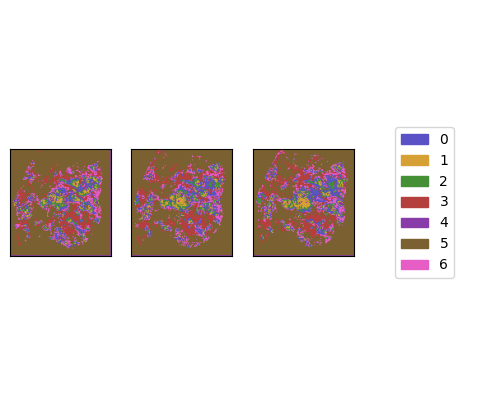

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

he 1


INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned


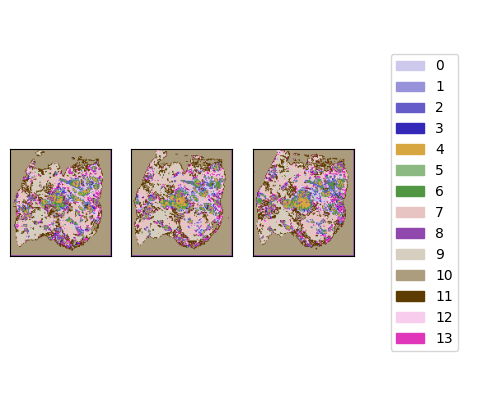

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

he 2


INFO:fontTools.subset:gasp subsetting not needed
INFO:fontTools.subset:MATH subsetted
INFO:fontTools.subset:GDEF subsetted
INFO:fontTools.subset:GPOS subsetted
INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned


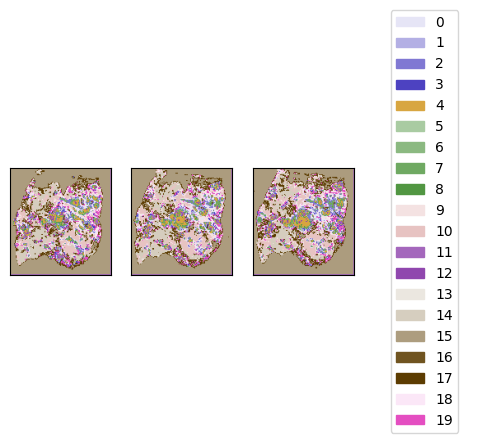

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 12 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 12 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26]
INFO:fontTools.subset:Closing g

multiplex 0


INFO:fontTools.subset:GDEF subsetted
INFO:fontTools.subset:GPOS subsetted
INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned


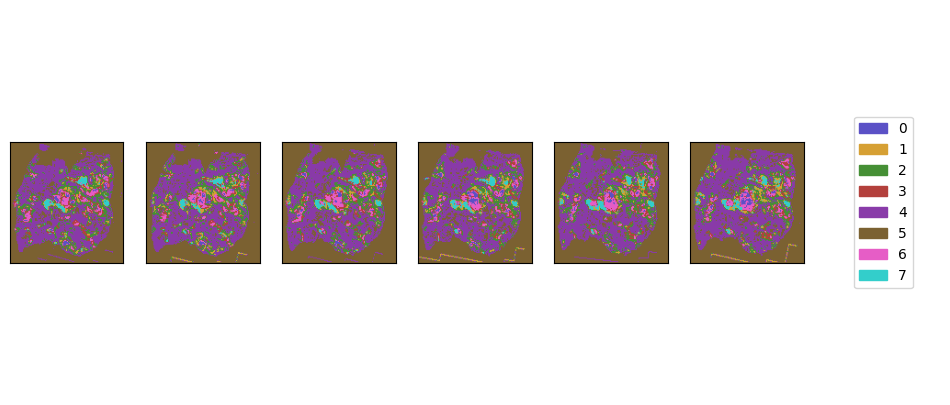

multiplex 1


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

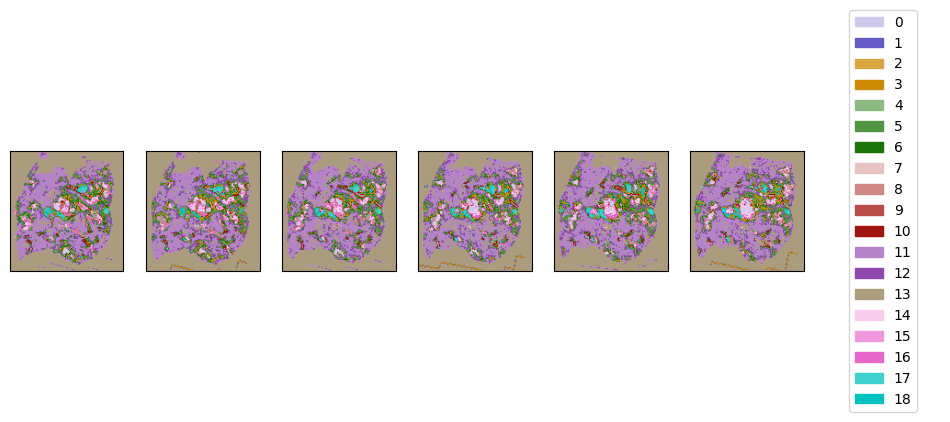

multiplex 2


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

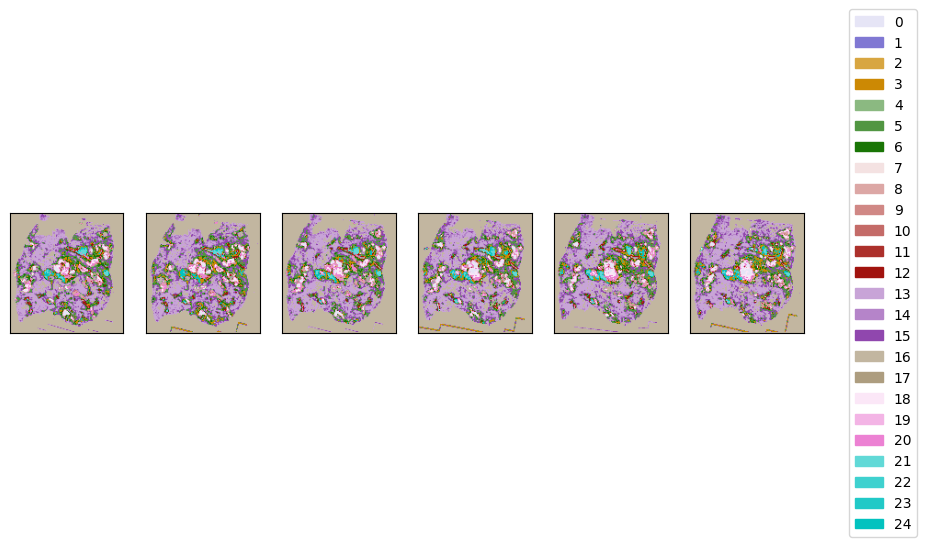

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 11 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 11 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25]
INFO:fontTools.subset:Closing glyph list over 'MATH': 11 

xenium 0


INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned


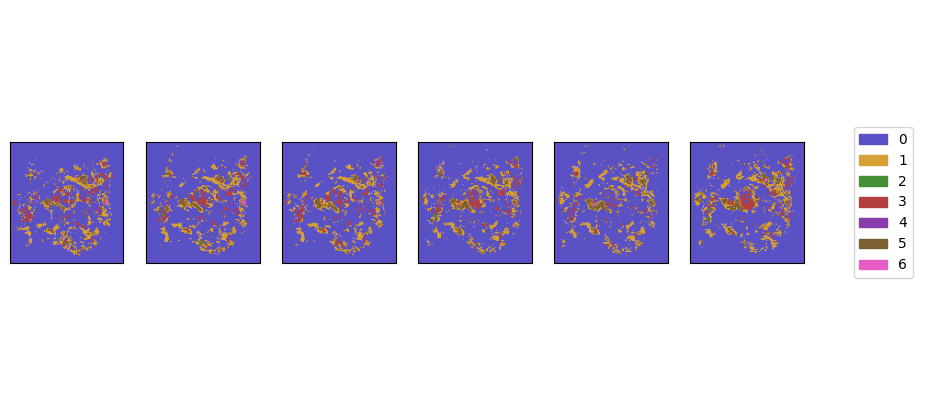

INFO:fontTools.subset:maxp pruned


xenium 1


INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.

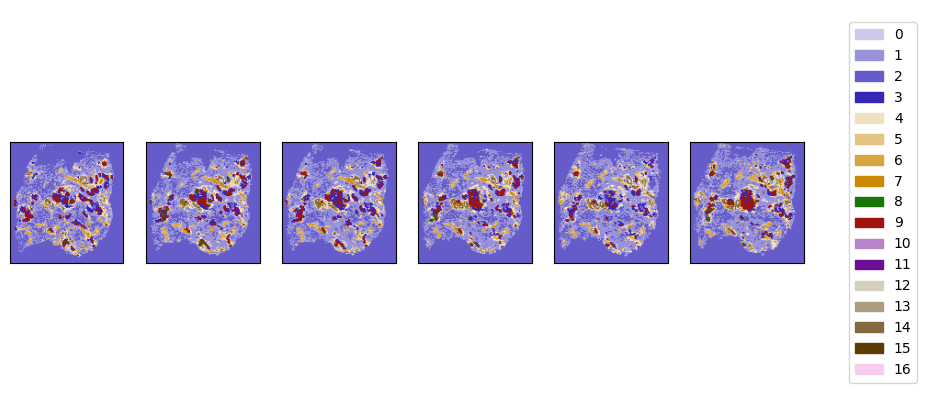

xenium 2


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

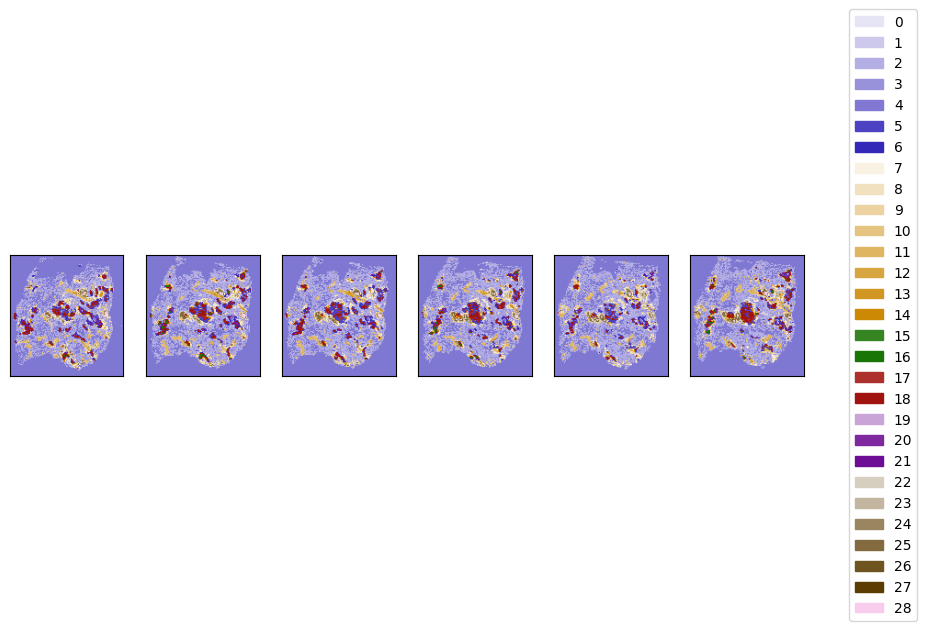

INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore


0


INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 72900 edges
INFO:root:1680 edges remaining after filtering
INFO:root:270 of 270 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 8 clusters
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 18 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'd', 'e', 'g', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'p', 'r', 'space', 't', 'u', 'x']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 68, 71, 72, 74, 75,

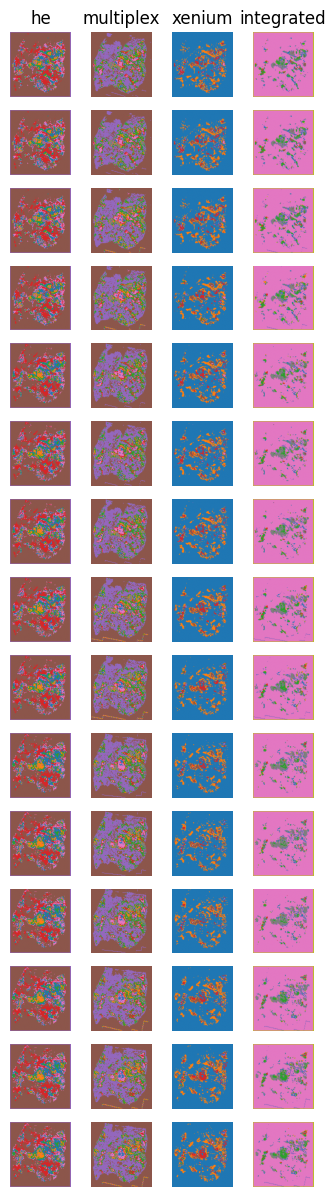

INFO:root:generating volume for he spore


1


INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 2829124 edges
INFO:root:51148 edges remaining after filtering
INFO:root:1682 of 1682 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 12 clusters
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 18 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'd', 'e', 'g', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'p', 'r', 'space', 't', 'u', 'x']
INFO:fontTool

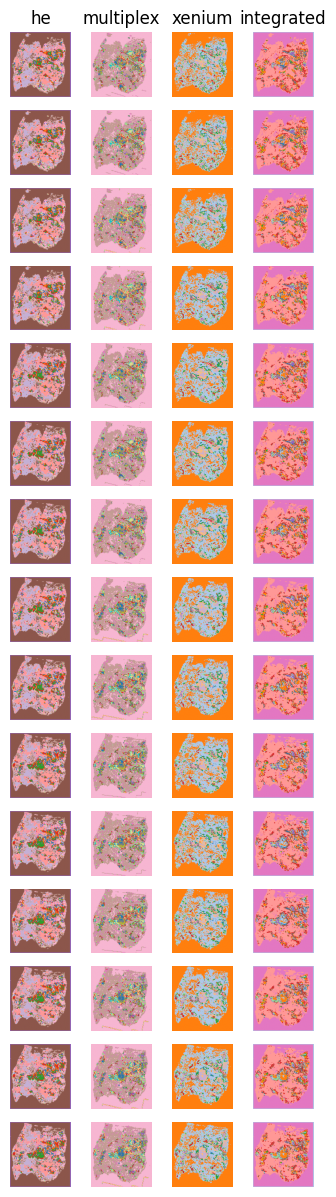

INFO:root:generating volume for he spore


2


INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 11628100 edges
INFO:root:208210 edges remaining after filtering
INFO:root:3410 of 3410 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 15 clusters
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 18 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'd', 'e', 'g', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'p', 'r', 'space', 't', 'u', 'x']
INFO:fontTo

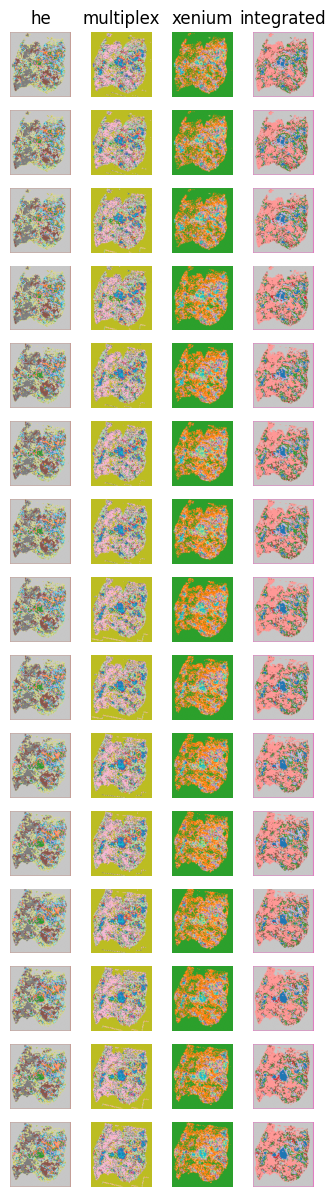

INFO:root:saving config and outputs to /data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res
INFO:root:loading spore for cosmx
INFO:root:data mask detected
INFO:root:starting cosmx processing


HT413C1-Th1k4A1 50


INFO:root:using 1000 channels
INFO:root:2 sections detected: ['HT413C1-Th1k4A1-U7', 'HT413C1-Th1k4A1-U34']
INFO:root:processing sections
INFO:root:generating image data for section HT413C1-Th1k4A1-U7
INFO:root:generating image data for section HT413C1-Th1k4A1-U34
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT413C1-Th1k4A1-U7', 'cosmx'), ('HT413C1-Th1k4A1-U34', 'cosmx')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for he
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:14 sections detected: ['HT413C1-Th1k4A1-U14', 'HT413C1-Th1k4A1-U18', 'HT413C1-Th1k4A1-U1', 'HT413C1-Th1k4A1-U4', 'HT413C1-Th1k4A1-U8', 'HT413C1-Th1k4A1-U11', 'HT413C1-Th1k4A1-U21', 'HT413C1-Th1k4A1-U24', 'HT413C1-

cosmx torch.Size([1000, 102, 73])
0.02


INFO:root:generating image data for section HT413C1-Th1k4A1-U18
INFO:root:generating image data for section HT413C1-Th1k4A1-U1
INFO:root:generating image data for section HT413C1-Th1k4A1-U4
INFO:root:generating image data for section HT413C1-Th1k4A1-U8
INFO:root:generating image data for section HT413C1-Th1k4A1-U11
INFO:root:generating image data for section HT413C1-Th1k4A1-U21
INFO:root:generating image data for section HT413C1-Th1k4A1-U24
INFO:root:generating image data for section HT413C1-Th1k4A1-U27
INFO:root:generating image data for section HT413C1-Th1k4A1-U29
INFO:root:generating image data for section HT413C1-Th1k4A1-U30
INFO:root:generating image data for section HT413C1-Th1k4A1-U35
INFO:root:generating image data for section HT413C1-Th1k4A1-U38
INFO:root:generating image data for section HT413C1-Th1k4A1-U40
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 14 sections detected: [('HT413C1-Th1k4A1-U14', 'he'), ('HT413C1-Th1k4A1-U18

he torch.Size([3, 101, 72])
0.02


INFO:root:generating image data for section HT413C1-Th1k4A1-U3
INFO:root:generating image data for section HT413C1-Th1k4A1-U26
INFO:root:generating image data for section HT413C1-Th1k4A1-U32
INFO:root:generating image data for section HT413C1-Th1k4A1-U37
INFO:root:generating image data for section HT413C1-Th1k4A1-U41
INFO:root:generating image data for section HT413C1-Th1k4A1-U42
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 7 sections detected: [('HT413C1-Th1k4A1-U20', 'multiplex'), ('HT413C1-Th1k4A1-U3', 'multiplex'), ('HT413C1-Th1k4A1-U26', 'multiplex'), ('HT413C1-Th1k4A1-U32', 'multiplex'), ('HT413C1-Th1k4A1-U37', 'multiplex'), ('HT413C1-Th1k4A1-U41', 'multiplex'), ('HT413C1-Th1k4A1-U42', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT


multiplex torch.Size([27, 101, 72])


INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for xenium
INFO:root:data mask detected
INFO:root:starting xenium processing
INFO:root:using 477 channels
INFO:root:5 sections detected: ['HT413C1-Th1k4A1-U19', 'HT413C1-Th1k4A1-U2', 'HT413C1-Th1k4A1-U9', 'HT413C1-Th1k4A1-U25', 'HT413C1-Th1k4A1-U36']
INFO:root:processing sections
INFO:root:generating image data for section HT413C1-Th1k4A1-U19
INFO:root:generating image data for section HT413C1-Th1k4A1-U2
INFO:root:generating image data for section HT413C1-Th1k4A1-U9
INFO:root:generating image data for section HT413C1-Th1k4A1-U25
INFO:root:generating image data for section HT413C1-Th1k4A1-U36
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 5 sections detected: [('HT413C1-Th1k4A1-U19', 'xenium'), ('HT413C1-Th1k4A1-U2', 'xenium'), ('HT413C1-

xenium torch.Size([477, 102, 73])
[('HT413C1-Th1k4A1-U14', 'he'), ('HT413C1-Th1k4A1-U18', 'he'), ('HT413C1-Th1k4A1-U19', 'xenium'), ('HT413C1-Th1k4A1-U20', 'multiplex'), ('HT413C1-Th1k4A1-U1', 'he'), ('HT413C1-Th1k4A1-U2', 'xenium'), ('HT413C1-Th1k4A1-U3', 'multiplex'), ('HT413C1-Th1k4A1-U4', 'he'), ('HT413C1-Th1k4A1-U7', 'cosmx'), ('HT413C1-Th1k4A1-U8', 'he'), ('HT413C1-Th1k4A1-U9', 'xenium'), ('HT413C1-Th1k4A1-U11', 'he'), ('HT413C1-Th1k4A1-U21', 'he'), ('HT413C1-Th1k4A1-U24', 'he'), ('HT413C1-Th1k4A1-U25', 'xenium'), ('HT413C1-Th1k4A1-U26', 'multiplex'), ('HT413C1-Th1k4A1-U27', 'he'), ('HT413C1-Th1k4A1-U29', 'he'), ('HT413C1-Th1k4A1-U30', 'he'), ('HT413C1-Th1k4A1-U32', 'multiplex'), ('HT413C1-Th1k4A1-U34', 'cosmx'), ('HT413C1-Th1k4A1-U35', 'he'), ('HT413C1-Th1k4A1-U36', 'xenium'), ('HT413C1-Th1k4A1-U37', 'multiplex'), ('HT413C1-Th1k4A1-U38', 'he'), ('HT413C1-Th1k4A1-U40', 'he'), ('HT413C1-Th1k4A1-U41', 'multiplex'), ('HT413C1-Th1k4A1-U42', 'multiplex')]
cosmx torch.Size([1000, 102, 

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/cosmx_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 6.7 M 
------------------------------
6.7 M     Trainable params
0         Non-trainable params
6.7 M     Total params
26.969    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training cosmx, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/cosmx_chkpts/last-v3.ckpt
INFO:root:starting training for he
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/he_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.874    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training he, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/he_chkpts/last-v3.ckpt
INFO:root:starting training for multiplex
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/multiplex_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.918    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training multiplex, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/multiplex_chkpts/last-v3.ckpt
INFO:root:starting training for xenium
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/xenium_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.2 M 
------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.992    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training xenium, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/xenium_chkpts/last-v3.ckpt
INFO:root:embedding cosmx spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 12 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 12 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26]
INFO:fontTools.subset:Closing g

cosmx 0


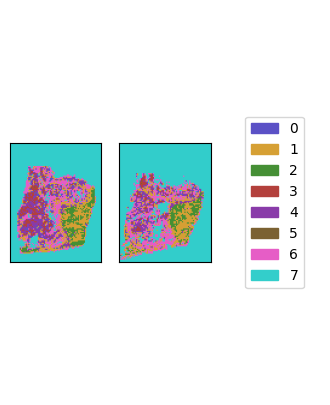

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

cosmx 1


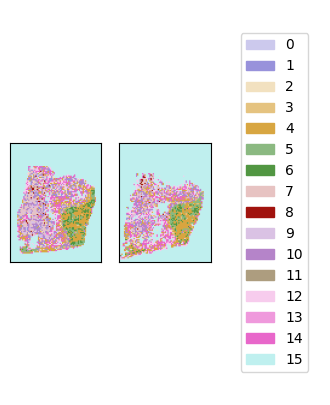

cosmx 2


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

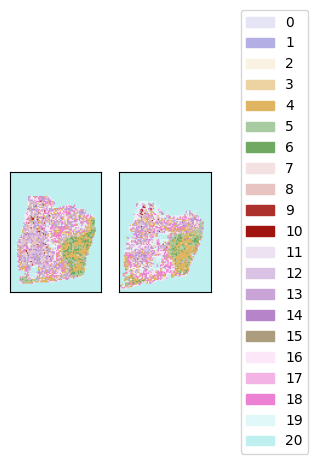

he 0


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 12 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 12 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26]
INFO:fontTools.subset:Closing g

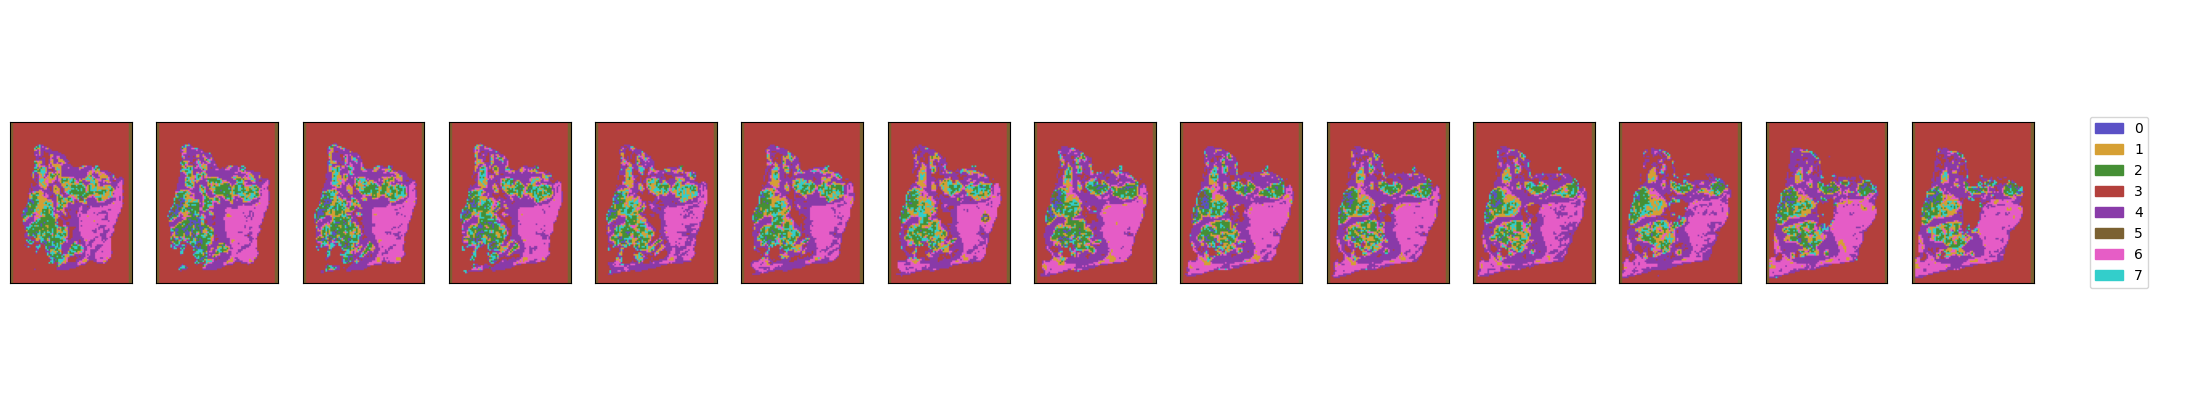

he 1


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

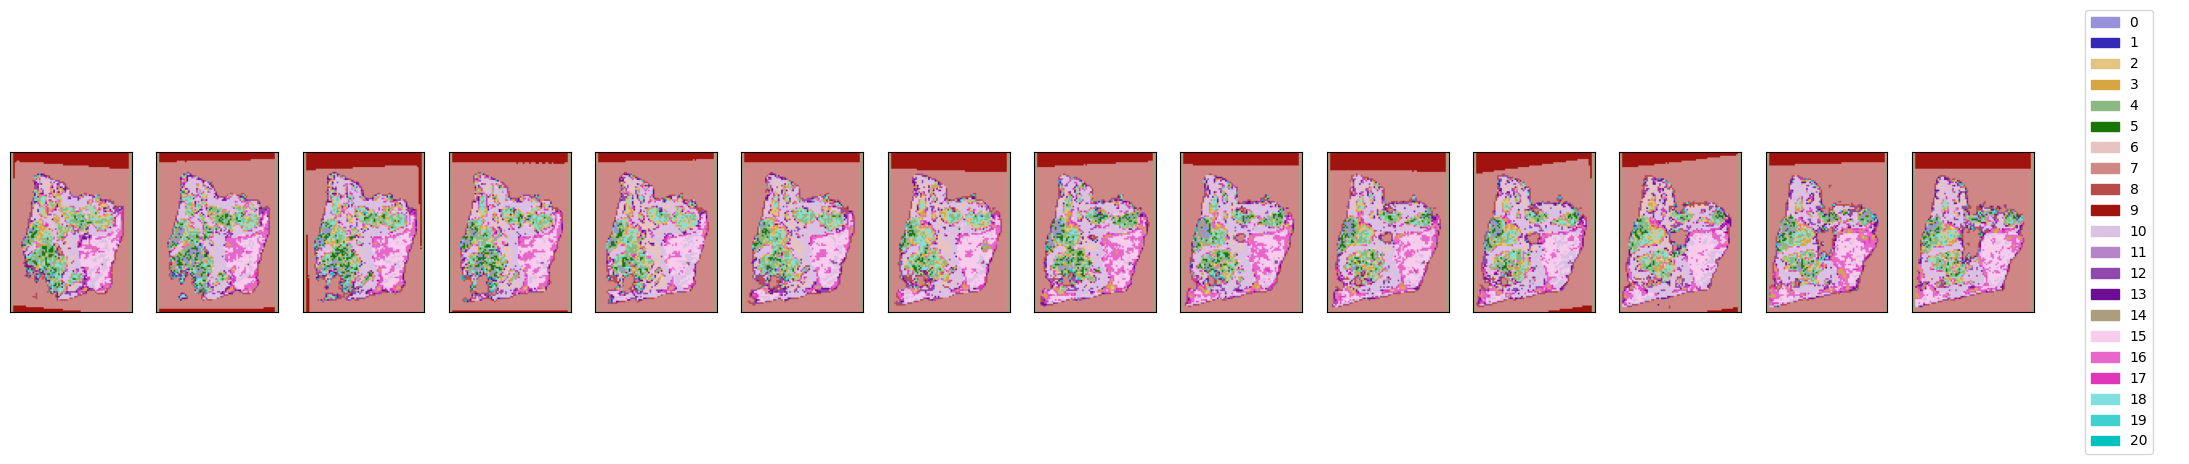

he 2


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

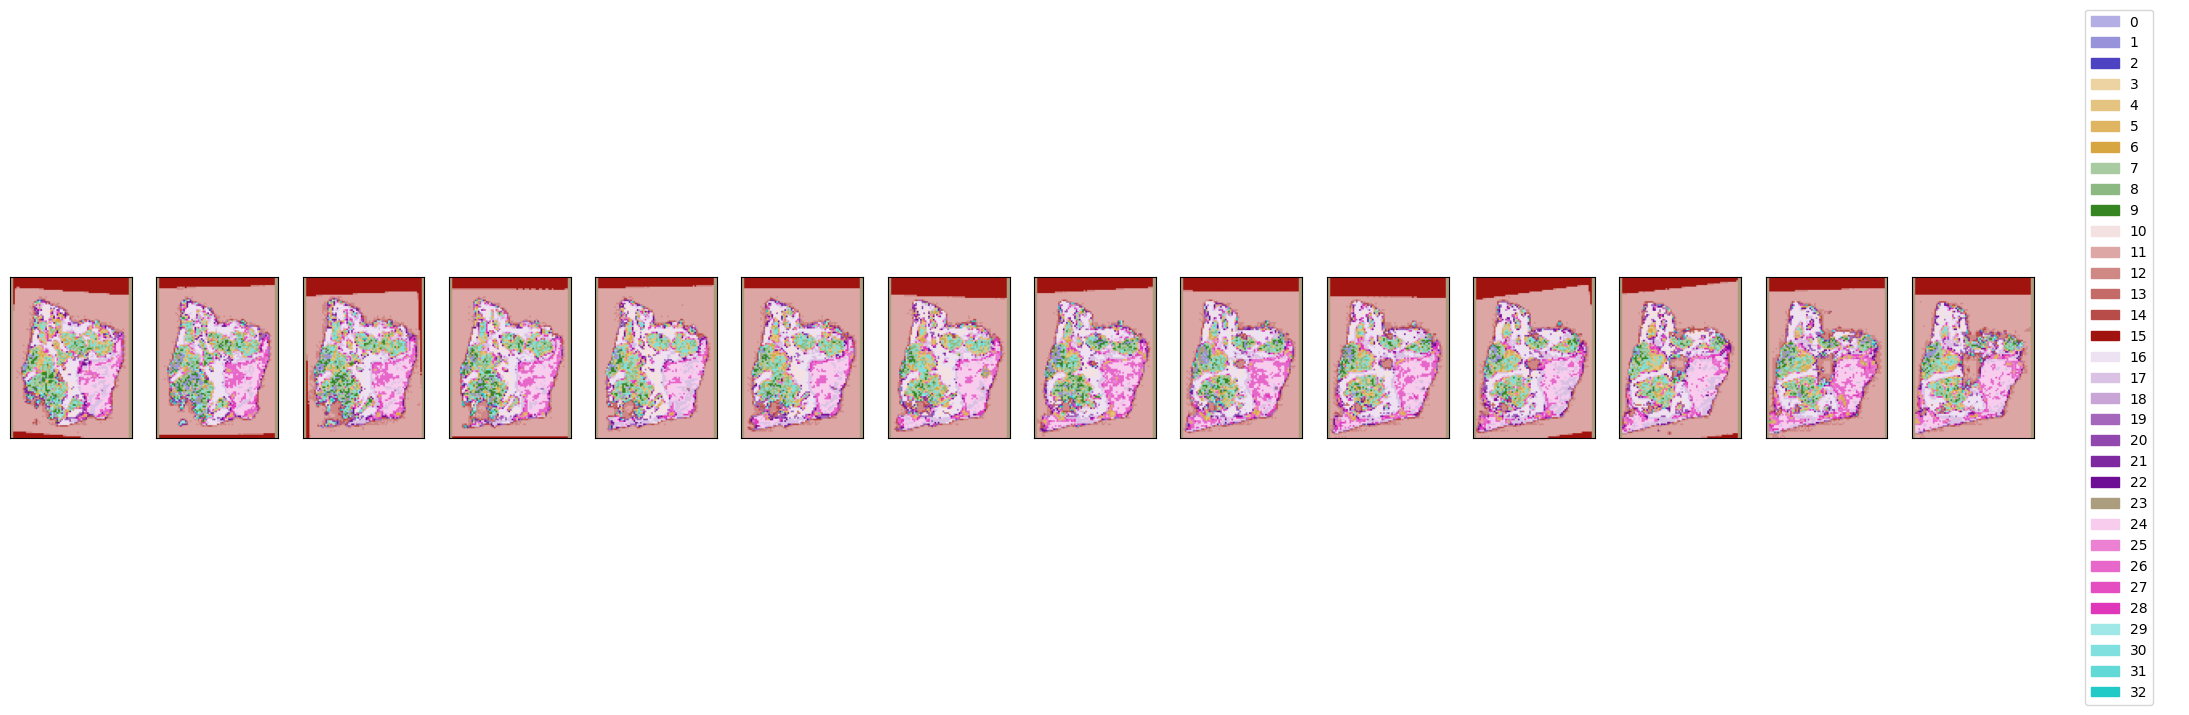

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 12 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 12 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26]
INFO:fontTools.subset:Closing g

multiplex 0


INFO:fontTools.subset:head subsetting not needed
INFO:fontTools.subset:hhea subsetting not needed
INFO:fontTools.subset:maxp subsetting not needed
INFO:fontTools.subset:OS/2 subsetting not needed
INFO:fontTools.subset:hmtx subsetted
INFO:fontTools.subset:cmap subsetted
INFO:fontTools.subset:fpgm subsetting not needed
INFO:fontTools.subset:prep subsetting not needed
INFO:fontTools.subset:cvt  subsetting not needed
INFO:fontTools.subset:loca subsetting not needed
INFO:fontTools.subset:post subsetted
INFO:fontTools.subset:gasp subsetting not needed
INFO:fontTools.subset:MATH subsetted
INFO:fontTools.subset:GDEF subsetted
INFO:fontTools.subset:GPOS subsetted
INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INF

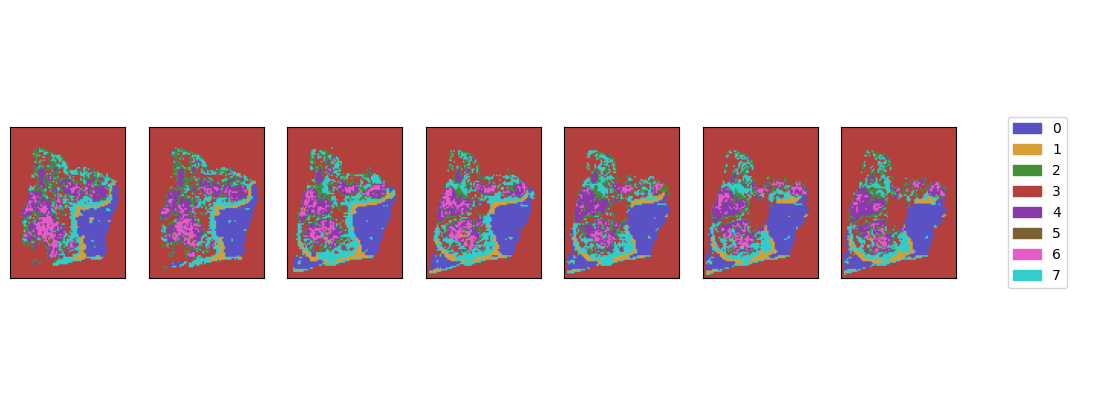

multiplex 1


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

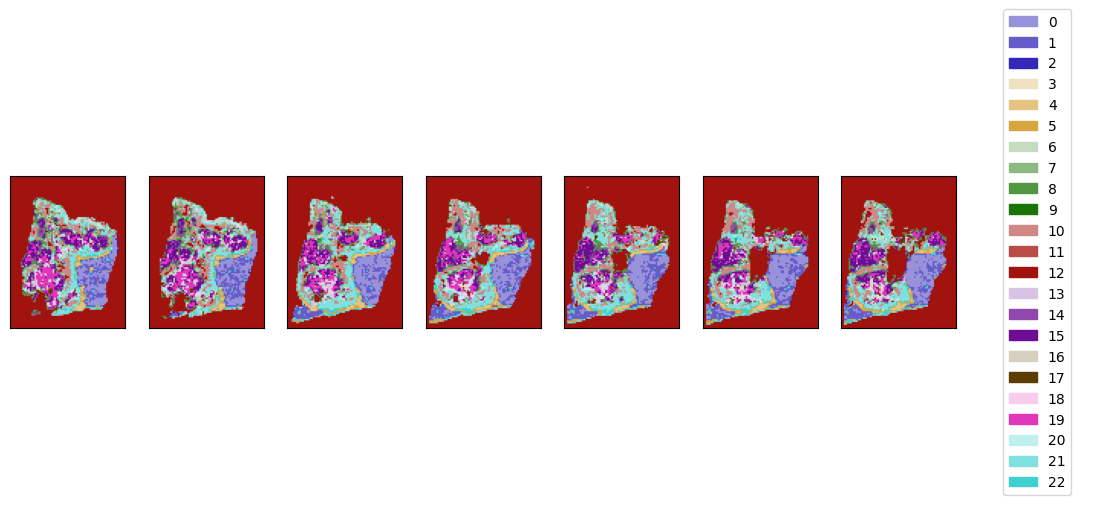

multiplex 2


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

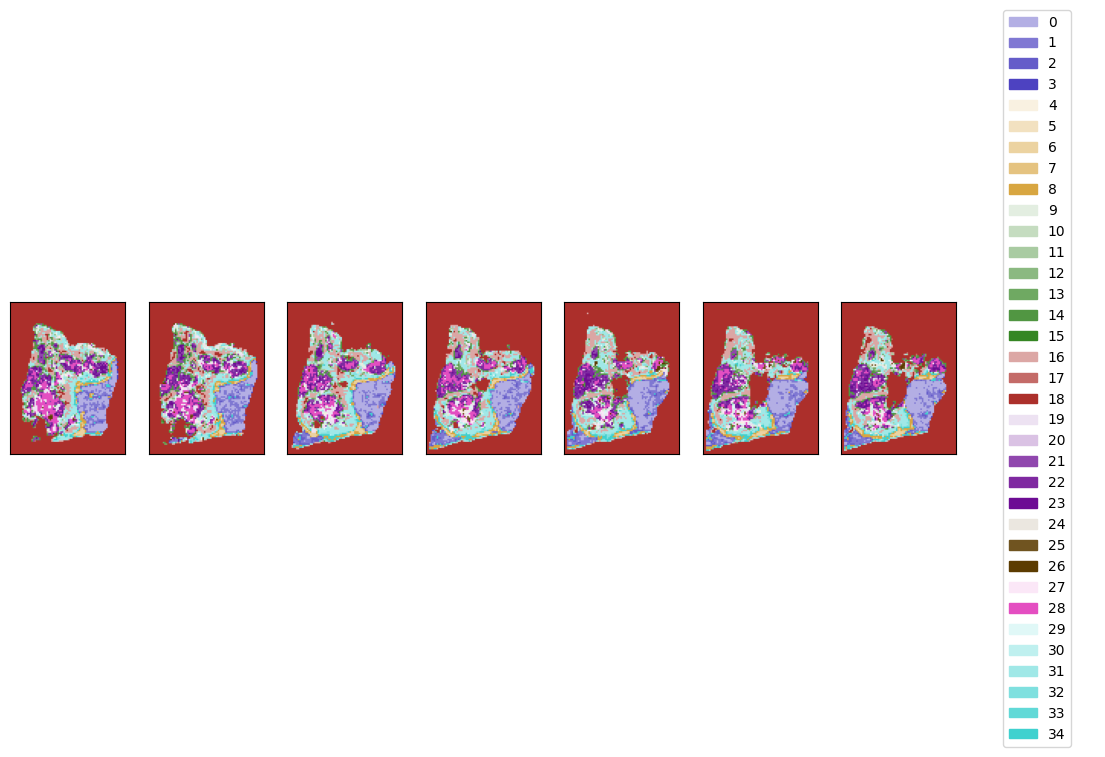

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 12 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 12 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26]
INFO:fontTools.subset:Closing g

xenium 0


INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned


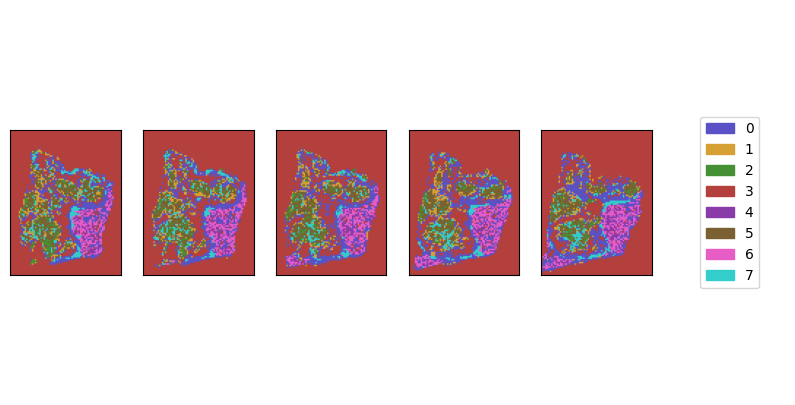

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned


xenium 1


INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closing glyph list over 'MATH': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 

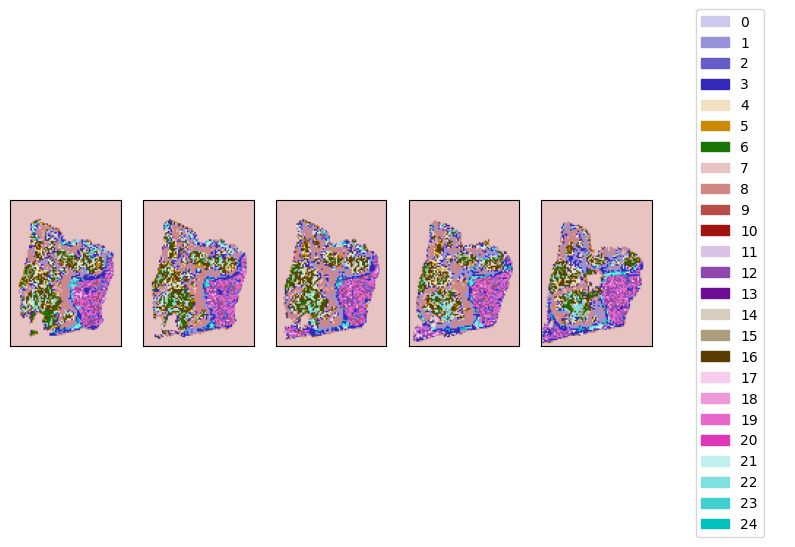

xenium 2


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

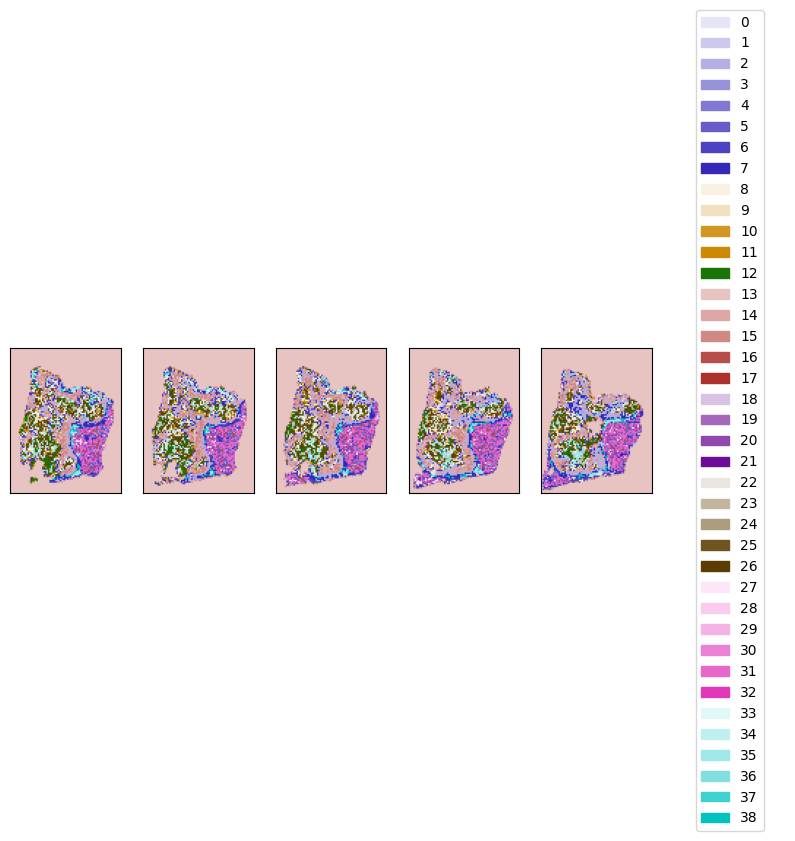

INFO:root:generating volume for cosmx spore
INFO:root:generating volume for he spore


0


INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 2396304 edges
INFO:root:39172 edges remaining after filtering
INFO:root:1548 of 1548 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 7 clusters
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 21 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'd', 'e', 'g', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't', 'u', 'x']

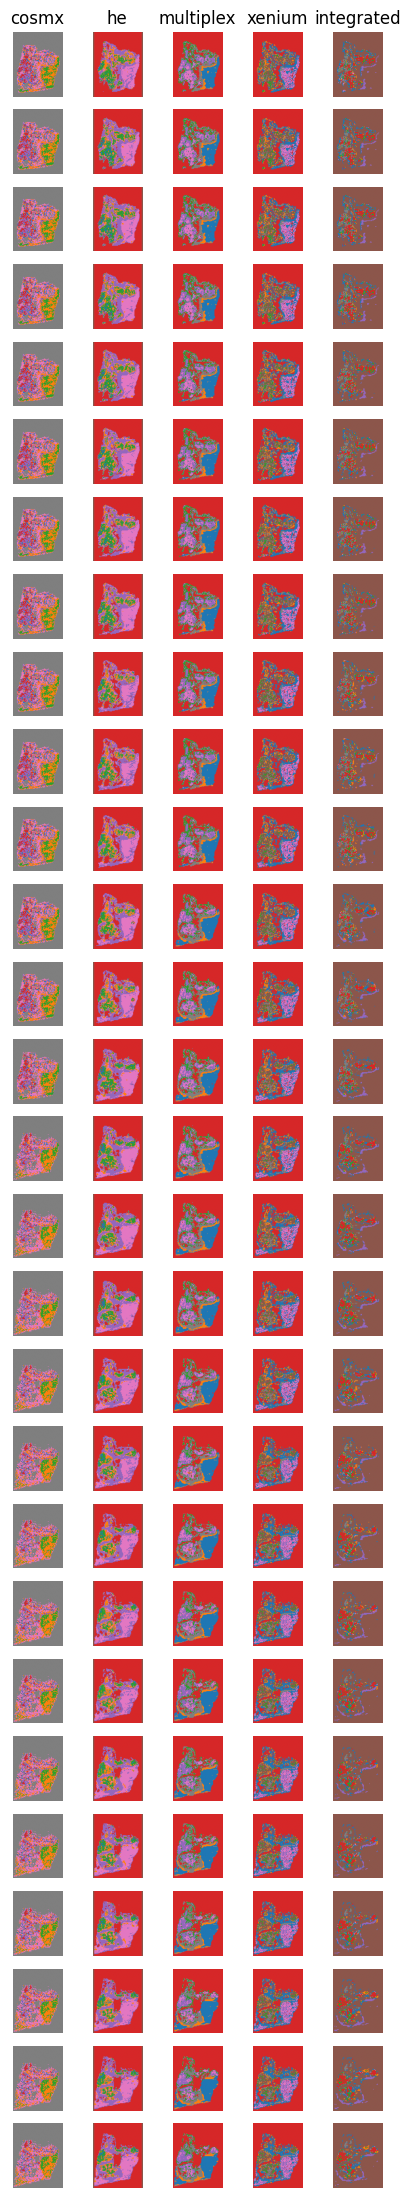

INFO:root:generating volume for cosmx spore


1


INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 129026881 edges
INFO:root:1363517 edges remaining after filtering
INFO:root:11359 of 11359 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 12 clusters
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 21 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'd', 'e', 'g', 'h', 'i', 'l', 'm', 'n', 'nonmarkingretu

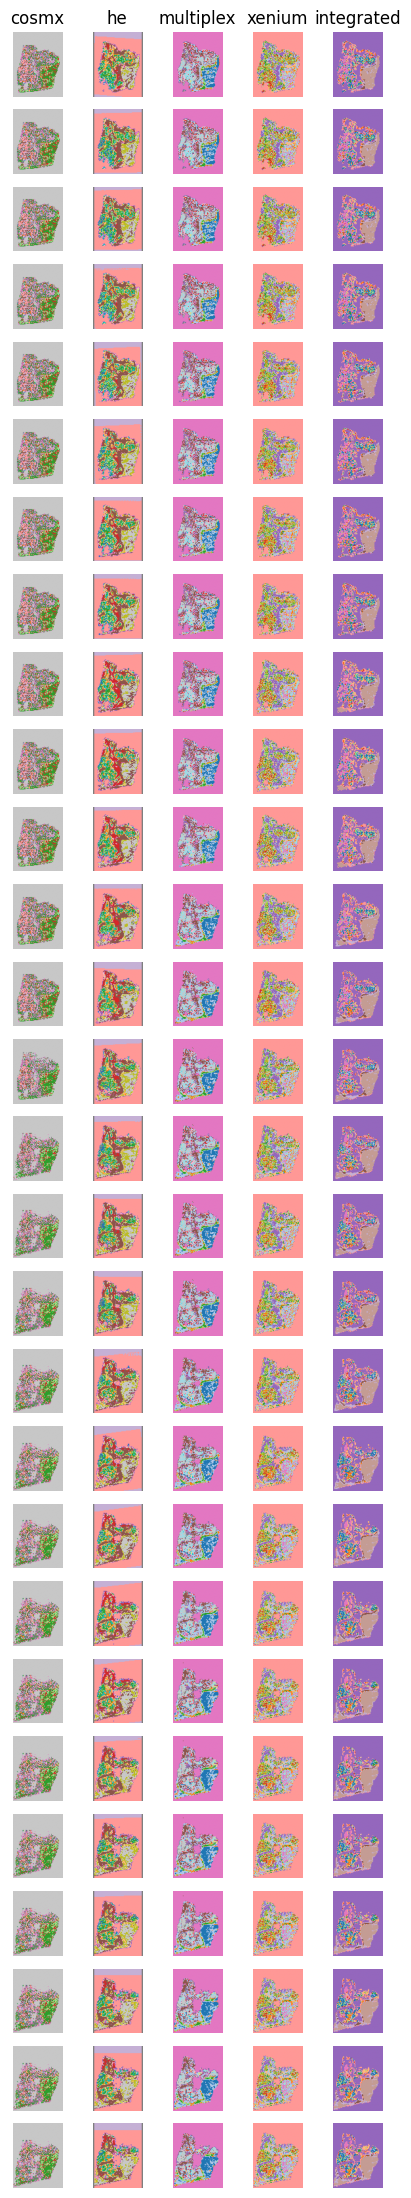

INFO:root:generating volume for cosmx spore


2


INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 427703761 edges
INFO:root:4835469 edges remaining after filtering
INFO:root:20681 of 20681 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 14 clusters
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 21 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'd', 'e', 'g', 'h', 'i', 'l', 'm', 'n', 'nonmarkingretu

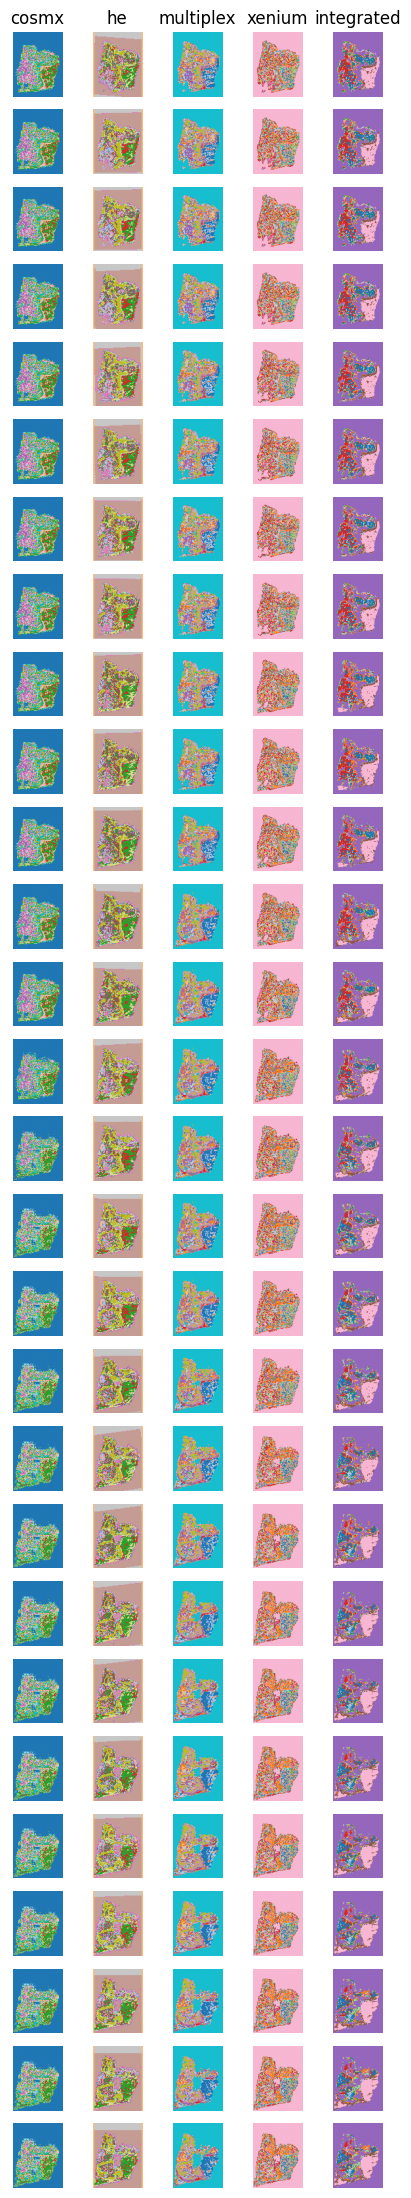

INFO:root:saving config and outputs to /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res


In [23]:
for (case, target_res), config in case_to_config.items():
    print(case, target_res)
    dtype_to_weight = dtype_to_weight_mapping.get(case)
    
    mushroom = Mushroom.from_config(config)
    print(mushroom.section_ids)
    for dt in mushroom.dtypes:
        x = next(iter(mushroom.dtype_to_spore[dt].train_dl.dataset.section_to_img.values()))
        print(dt, x.shape)
        print(mushroom.input_ppm, mushroom.target_ppm)
    mushroom.train()
    mushroom.embed_sections()
    
    out_dir = mushroom.trainer_kwargs['out_dir']
    fig_dir = os.path.join(out_dir, 'figures')
    Path(fig_dir).mkdir(parents=True, exist_ok=True)
    
    for dtype in mushroom.dtypes:
        for level in range(mushroom.num_levels):
            print(dtype, level)
            mushroom.display_clusters(dtype, level=level)
            plt.savefig(os.path.join(fig_dir, f'nbhds_{dtype}_l{level}.pdf'), dpi=300)
            plt.savefig(os.path.join(fig_dir, f'nbhds_{dtype}_l{level}.png'), dpi=300)
            plt.show()
            
    for level, cluster_res in enumerate(cluster_resolutions):
        print(level)
        dtype_to_volume = mushroom.generate_interpolated_volumes(
            z_scaler=z_scaler, level=level, integrate=True, dtype_to_weight=dtype_to_weight, resolution=cluster_res)
#         dtype_to_volume = mushroom.generate_interpolated_volumes(
#             z_scaler=z_scaler, level=level, integrate=False, dtype_to_weight=dtype_to_weight, resolution=cluster_res)
        dtype_to_volume_labels = {k:v.argmax(-1) if k != 'integrated' else v for k, v in dtype_to_volume.items()}

        mushroom.display_volumes(dtype_to_volume=dtype_to_volume_labels, positions=mushroom.section_positions)

        plt.savefig(os.path.join(fig_dir, f'nbhd_volumes_l{level}.pdf'), dpi=300)
        plt.savefig(os.path.join(fig_dir, f'nbhd_volumes_l{level}.png'), dpi=300)
        plt.show()

        pickle.dump({
            'probs': dtype_to_volume,
            'labeled': dtype_to_volume_labels
        }, open(os.path.join(out_dir, f'nbhd_volumes_l{level}.pkl'), 'wb'), protocol=4)

        del(dtype_to_volume)
        del(dtype_to_volume_labels)
        
    clustering_params = {
        'z_scaler': z_scaler,
        'cluster_resolutions': cluster_resolutions,
        'dtype_to_weight': dtype_to_weight
    }
    yaml.safe_dump(clustering_params, open(os.path.join(out_dir, 'nbhd_volume_params.yaml'), 'w'))
    
    mushroom.save()
    
    del(mushroom)
